In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

1. Data loading

In [2]:
#Read csv file to dataframe
#=====your code here==========

spark = SparkSession.builder \
    .appName('CSV_Handler').getOrCreate()

data = spark.read.options(header=False, inferSchema=True) \
    .csv('./adult.data.csv')

#===============================
data.show(3)

+---+-----------------+--------+----------+----+-------------------+------------------+--------------+------+-----+------+----+----+--------------+------+
|_c0|              _c1|     _c2|       _c3| _c4|                _c5|               _c6|           _c7|   _c8|  _c9|  _c10|_c11|_c12|          _c13|  _c14|
+---+-----------------+--------+----------+----+-------------------+------------------+--------------+------+-----+------+----+----+--------------+------+
| 39|        State-gov| 77516.0| Bachelors|13.0|      Never-married|      Adm-clerical| Not-in-family| White| Male|2174.0| 0.0|40.0| United-States| <=50K|
| 50| Self-emp-not-inc| 83311.0| Bachelors|13.0| Married-civ-spouse|   Exec-managerial|       Husband| White| Male|   0.0| 0.0|13.0| United-States| <=50K|
| 38|          Private|215646.0|   HS-grad| 9.0|           Divorced| Handlers-cleaners| Not-in-family| White| Male|   0.0| 0.0|40.0| United-States| <=50K|
+---+-----------------+--------+----------+----+-------------------+--

In [3]:
from functools import reduce

In [4]:
#change the column names of dataframe
df = data.withColumnRenamed('_c0','age').withColumnRenamed('_c1','workclass').withColumnRenamed('_c2','fnlwgt')\
.withColumnRenamed('_c3', 'education').withColumnRenamed('_c4', 'education_num')\
.withColumnRenamed('_c5','marital_status').withColumnRenamed('_c6', 'occupation').withColumnRenamed('_c7', 'relationship')\
.withColumnRenamed('_c8', 'race').withColumnRenamed('_c9', 'sex').withColumnRenamed('_c10', 'capital_gain')\
.withColumnRenamed('_c11', 'capital_loss').withColumnRenamed('_c12','hours_per_week')\
.withColumnRenamed('_c13', 'native_country').withColumnRenamed('_c14', 'income')

df.printSchema()
df.show(2)

dataset = df

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)

+---+-----------------+-------+----------+-------------+-------------------+----------------+--------------+------+-----+------------+------------+--------------+--------------+------+
|age|        workclass| fnlwgt| education|education_num|     marital_status|      occupation|  relationship|  race|  sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+-

2. Data preprocessing

In [5]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

In [6]:
#stages in our Pipeline
stages = []
categoricalColumns = ["workclass","education","marital_status","occupation","relationship","race","sex","native_country"]

In [7]:
for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]


In [8]:
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="income", outputCol="label")
stages += [label_stringIdx]

In [9]:
# Transform all features into a vector using VectorAssembler
numericCols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [10]:
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(dataset)
preppedDataDF = pipelineModel.transform(dataset)

In [11]:
preppedDataDF.take(3)

[Row(age=39, workclass=' State-gov', fnlwgt=77516.0, education=' Bachelors', education_num=13.0, marital_status=' Never-married', occupation=' Adm-clerical', relationship=' Not-in-family', race=' White', sex=' Male', capital_gain=2174.0, capital_loss=0.0, hours_per_week=40.0, native_country=' United-States', income=' <=50K', workclassIndex=4.0, workclassclassVec=SparseVector(8, {4: 1.0}), educationIndex=2.0, educationclassVec=SparseVector(15, {2: 1.0}), marital_statusIndex=1.0, marital_statusclassVec=SparseVector(6, {1: 1.0}), occupationIndex=3.0, occupationclassVec=SparseVector(14, {3: 1.0}), relationshipIndex=1.0, relationshipclassVec=SparseVector(5, {1: 1.0}), raceIndex=0.0, raceclassVec=SparseVector(4, {0: 1.0}), sexIndex=0.0, sexclassVec=SparseVector(1, {0: 1.0}), native_countryIndex=0.0, native_countryclassVec=SparseVector(41, {0: 1.0}), label=0.0, features=SparseVector(100, {4: 1.0, 10: 1.0, 24: 1.0, 32: 1.0, 44: 1.0, 48: 1.0, 52: 1.0, 53: 1.0, 94: 39.0, 95: 77516.0, 96: 13.0, 9

In [12]:
# Keep relevant columns
cols = dataset.columns
selectedcols = ["label", "features"] + cols
dataset = preppedDataDF.select(selectedcols)
display(dataset)

DataFrame[label: double, features: vector, age: int, workclass: string, fnlwgt: double, education: string, education_num: double, marital_status: string, occupation: string, relationship: string, race: string, sex: string, capital_gain: double, capital_loss: double, hours_per_week: double, native_country: string, income: string]

In [13]:
### Randomly split data into training and test sets. set seed for reproducibility
#=====your code here==========

[trainingData, testData] = dataset.randomSplit([0.7, 0.3], seed=100)

method_list = []
accuracy_list = []

#===============================
print(trainingData.count())
print(testData.count())

22832
9729


3. Modeling

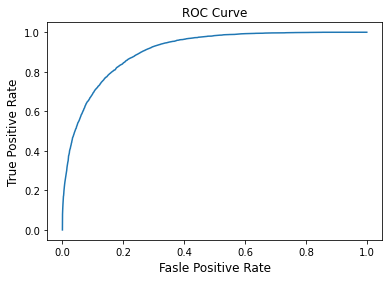

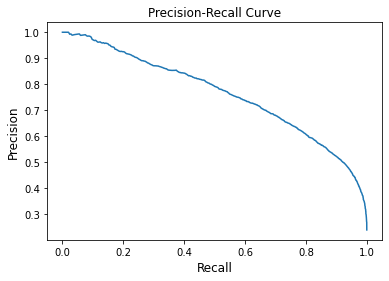

+-----+----------+--------------------+
|label|prediction|            features|
+-----+----------+--------------------+
|  0.0|       1.0|(100,[0,8,23,29,4...|
|  0.0|       0.0|(100,[0,8,23,29,4...|
|  0.0|       1.0|(100,[0,8,23,29,4...|
|  0.0|       0.0|(100,[0,8,23,29,4...|
|  0.0|       0.0|(100,[0,8,23,29,4...|
+-----+----------+--------------------+
only showing top 5 rows

Test set accuracy = 0.8446911296124987


In [14]:
# Fit model to prepped data

#LogisticRegression model, maxIter=10
#=====your code here==========

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

lr = LogisticRegression(maxIter=10)

lrModel = lr.fit(trainingData)

trainingSummary = lrModel.summary

roc = trainingSummary.roc
roc = roc.rdd.map(lambda row: (row["FPR"], row["TPR"])).collect()
fp, tp = [x[0] for x in roc], [x[1] for x in roc]
plt.plot(fp, tp)
plt.xlabel("Fasle Positive Rate", fontdict={'weight': 'normal', 'size': 12})
plt.ylabel("True Positive Rate", fontdict={'weight': 'normal', 'size': 12})
plt.title("ROC Curve")
plt.show()

pr = trainingSummary.pr
pr = pr.rdd.map(lambda row: (row["recall"], row["precision"])).collect()
r, p = [x[0] for x in pr], [x[1] for x in pr]
plt.plot(r, p)
plt.xlabel("Recall", fontdict={'weight': 'normal', 'size': 12})
plt.ylabel("Precision", fontdict={'weight': 'normal', 'size': 12})
plt.title("Precision-Recall Curve")
plt.show()
#===============================

# select example rows to display.
predictions = lrModel.transform(testData)
predictions.select("label", "prediction", "features").show(5)

# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))

method_list.append("LR")
accuracy_list.append(accuracy)

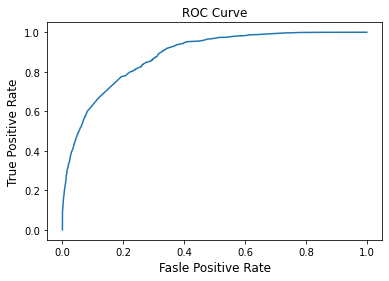

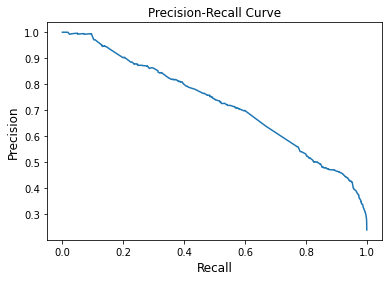

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|           0.0|  0.0|(100,[0,8,23,29,4...|
|           0.0|  0.0|(100,[0,8,23,29,4...|
|           0.0|  0.0|(100,[0,8,23,29,4...|
|           0.0|  0.0|(100,[0,8,23,29,4...|
|           0.0|  0.0|(100,[0,8,23,29,4...|
+--------------+-----+--------------------+
only showing top 5 rows

Test set accuracy = 0.8173501901531504


In [15]:
#Random Forest

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(dataset)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer = \
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(dataset)


# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

# Train model.  This also runs the indexers.
rfModel = pipeline.fit(trainingData)

trainingSummary = rfModel.stages[-2].summary

roc = trainingSummary.roc
roc = roc.rdd.map(lambda row: (row["FPR"], row["TPR"])).collect()
fp, tp = [x[0] for x in roc], [x[1] for x in roc]
plt.plot(fp, tp)
plt.xlabel("Fasle Positive Rate", fontdict={'weight': 'normal', 'size': 12})
plt.ylabel("True Positive Rate", fontdict={'weight': 'normal', 'size': 12})
plt.title("ROC Curve")
plt.show()

pr = trainingSummary.pr
pr = pr.rdd.map(lambda row: (row["recall"], row["precision"])).collect()
r, p = [x[0] for x in pr], [x[1] for x in pr]
plt.plot(r, p)
plt.xlabel("Recall", fontdict={'weight': 'normal', 'size': 12})
plt.ylabel("Precision", fontdict={'weight': 'normal', 'size': 12})
plt.title("Precision-Recall Curve")
plt.show()

# Make predictions.
predictions = rfModel.transform(testData)

# Select example rows to display.
predictions.select("predictedLabel", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))

method_list.append("RF")
accuracy_list.append(accuracy)

In [16]:
#NaiveBayes
#=====your code here==========

from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# create the trainer and set its parameters
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

# train the model
nbModel = nb.fit(trainingData)

#===============================

# select example rows to display.
predictions = nbModel.transform(testData)
predictions.select("label", "prediction", "features").show(5)

# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))

method_list.append("NB")
accuracy_list.append(accuracy)

+-----+----------+--------------------+
|label|prediction|            features|
+-----+----------+--------------------+
|  0.0|       0.0|(100,[0,8,23,29,4...|
|  0.0|       0.0|(100,[0,8,23,29,4...|
|  0.0|       0.0|(100,[0,8,23,29,4...|
|  0.0|       0.0|(100,[0,8,23,29,4...|
|  0.0|       0.0|(100,[0,8,23,29,4...|
+-----+----------+--------------------+
only showing top 5 rows

Test set accuracy = 0.7796279165381849


In [17]:
#Decision Tree

from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(dataset)

# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer = \
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(dataset)

# Train a DecisionTree model.
dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dt])

# Train model.  This also runs the indexers.
dtModel = pipeline.fit(trainingData)

# Make predictions.
predictions = dtModel.transform(testData)

# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = ", str(accuracy))

method_list.append("DT")
accuracy_list.append(accuracy)

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       0.0|         0.0|(100,[0,8,23,29,4...|
|       0.0|         0.0|(100,[0,8,23,29,4...|
|       0.0|         0.0|(100,[0,8,23,29,4...|
|       0.0|         0.0|(100,[0,8,23,29,4...|
|       0.0|         0.0|(100,[0,8,23,29,4...|
+----------+------------+--------------------+
only showing top 5 rows

Test set accuracy =  0.8367766471374242


In [18]:
#Gradient Boosting Trees

from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(dataset)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer = \
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(dataset)

# Train a GBT model.
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=10)

# Chain indexers and GBT in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, gbt])

# Train model.  This also runs the indexers.
gbtModel = pipeline.fit(trainingData)

# Make predictions.
predictions = gbtModel.transform(testData)

# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = ", str(accuracy))

method_list.append("GBT")
accuracy_list.append(accuracy)

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       1.0|         0.0|(100,[0,8,23,29,4...|
|       0.0|         0.0|(100,[0,8,23,29,4...|
|       0.0|         0.0|(100,[0,8,23,29,4...|
|       0.0|         0.0|(100,[0,8,23,29,4...|
|       0.0|         0.0|(100,[0,8,23,29,4...|
+----------+------------+--------------------+
only showing top 5 rows

Test set accuracy =  0.8477746942131771


In [19]:
# Multi-layer Perceptron

from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

layers = [100, 64, 32, 16, 2]

# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=100)

# train the model
mlpModel = trainer.fit(trainingData)

# compute accuracy on the test set
predictions = mlpModel.transform(testData)

# Select example rows to display.
predictions.select("prediction", "label", "features").show(5)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))

method_list.append("MLP")
accuracy_list.append(accuracy)

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       0.0|  0.0|(100,[0,8,23,29,4...|
|       0.0|  0.0|(100,[0,8,23,29,4...|
|       0.0|  0.0|(100,[0,8,23,29,4...|
|       0.0|  0.0|(100,[0,8,23,29,4...|
|       0.0|  0.0|(100,[0,8,23,29,4...|
+----------+-----+--------------------+
only showing top 5 rows

Test set accuracy = 0.7948401685681982


In [20]:
# Linear Support Vector Machine

from pyspark.ml.classification import LinearSVC

lsvc = LinearSVC(maxIter=10)

# Fit the model
lsvcModel = lsvc.fit(trainingData)

# compute accuracy on the test set
predictions = lsvcModel.transform(testData)

# Select example rows to display.
predictions.select("prediction", "label", "features").show(5)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))

method_list.append("LSVM")
accuracy_list.append(accuracy)

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       0.0|  0.0|(100,[0,8,23,29,4...|
|       0.0|  0.0|(100,[0,8,23,29,4...|
|       0.0|  0.0|(100,[0,8,23,29,4...|
|       0.0|  0.0|(100,[0,8,23,29,4...|
|       0.0|  0.0|(100,[0,8,23,29,4...|
+----------+-----+--------------------+
only showing top 5 rows

Test set accuracy = 0.7916538184808305


In [21]:
# One-vs-Rest

from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# instantiate the base classifier.
lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)

# instantiate the One Vs Rest Classifier.
ovr = OneVsRest(classifier=lr)

# train the multiclass model.
ovrModel = ovr.fit(trainingData)

# score the model on test data.
predictions = ovrModel.transform(testData)

# Select example rows to display.
predictions.select("prediction", "label", "features").show(5)

# obtain evaluator.
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# compute the classification error on test data.
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = ", str(accuracy))

method_list.append("OVR")
accuracy_list.append(accuracy)

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       1.0|  0.0|(100,[0,8,23,29,4...|
|       0.0|  0.0|(100,[0,8,23,29,4...|
|       1.0|  0.0|(100,[0,8,23,29,4...|
|       0.0|  0.0|(100,[0,8,23,29,4...|
|       0.0|  0.0|(100,[0,8,23,29,4...|
+----------+-----+--------------------+
only showing top 5 rows

Test set accuracy =  0.8446911296124987


4. Comparison and analysis

In [22]:
# Rank models according to Test set accuracy
#=====your code here==========

method_accuracy = dict(zip(method_list, accuracy_list))

res = sorted(method_accuracy.items(), key = lambda x: x[1], reverse=True)

for item in res:
    print("Method: %s; Accuracy: %f" % (item[0], item[1]))

#===============================

Method: GBT; Accuracy: 0.847775
Method: LR; Accuracy: 0.844691
Method: OVR; Accuracy: 0.844691
Method: DT; Accuracy: 0.836777
Method: RF; Accuracy: 0.817350
Method: MLP; Accuracy: 0.794840
Method: LSVM; Accuracy: 0.791654
Method: NB; Accuracy: 0.779628


Among all the methods, Gradient Boosting Tree achieves the highest accuracy, followed by Logistic Regression and One-vs-Rest. The Naive Beyes gives the poorest performance among all the methods. In the multi-layer Perception algprithm, if a deeper Perception model is used, the there will be an improvement on the accuracy.